# Gibbs textural filters comparison on BRATS data

We compare the performance of models trained on stylized datasets on differently stylized datasets.



The dataset comes from http://medicaldecathlon.com/.  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right).
(Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))

![image](../figures/brats_tasks.png)

The image patches show from left to right:
1. the whole tumor (yellow) visible in T2-FLAIR (Fig.A).
1. the tumor core (red) visible in T2 (Fig.B).
1. the enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
1. The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/3d_segmentation/brats_segmentation_3d.ipynb)

## Setup imports

In [1]:

import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

import torch
from torch.utils.data import random_split
from tqdm import tqdm

############################################
# Local imports

SOURCE_CODE_PATH = '/homes/yc7620/Documents/medical-vision-textural-bias/90_source_code/'
import sys
sys.path.append(SOURCE_CODE_PATH)

from filters_and_operators import RandFourierDiskMaskd, ConvertToMultiChannelBasedOnBratsClassesd
from utils import show_slice_and_fourier, model_evaluation
#############################################

# set determinism for reproducibility
set_determinism(seed=0)


root_dir = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/'
print('root_dir', root_dir)
print_config()

device = torch.device("cuda:0")

root_dir /vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/
MONAI version: 0.5.dev2113
Numpy version: 1.19.2
Pytorch version: 1.8.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: b3cc668c924b2a7e6b822416f4d920a098c27704

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.1.2
Tensorboard version: 1.15.0
gdown version: 3.12.2
TorchVision version: 0.9.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup transforms for each dataset

In [2]:
val_transform_baseline = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"])
    ]
)

val_transform_gibbs25 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        RandFourierDiskMaskd(keys='image', r=25 , inside_off=False, prob=1.)
    ]
)

val_transform_gibbs20 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        RandFourierDiskMaskd(keys='image', r=20 , inside_off=False, prob=1.)
    ]
)

val_transform_gibbs15 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        RandFourierDiskMaskd(keys='image', r=15 , inside_off=False, prob=1.)
    ]
)

val_transform_gibbs12p5 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        RandFourierDiskMaskd(keys='image', r=12.5 , inside_off=False, prob=1.)
    ]
)

val_transform_gibbs10 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        RandFourierDiskMaskd(keys='image', r=10 , inside_off=False, prob=1.)
    ]
)

val_transform_gibbs9 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        RandFourierDiskMaskd(keys='image', r=9 , inside_off=False, prob=1.)
    ]
)

######################################################

# Interval Gibbs

val_transform_gibbs10to25 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        RandFourierDiskMaskd(keys='image', r=[10,25.1] , inside_off=False, prob=1.)
    ]
)

## Load data with DecathlonDataset

In [3]:
# baseline
val_ds_baseline = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_baseline,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)

_ , test_ds_baseline = random_split(val_ds_baseline, [48, 48],
                                   torch.Generator().manual_seed(0))
test_loader_baseline = DataLoader(test_ds_baseline, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [00:51<00:00,  1.04s/it]


In [4]:
#Gibbs25
val_ds_gibbs25 = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_gibbs25,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)
_ , test_ds_gibbs25 = random_split(val_ds_gibbs25, [48, 48],
                                   torch.Generator().manual_seed(0))

test_loader_gibbs25 = DataLoader(test_ds_gibbs25, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [01:00<00:00,  1.20s/it]


In [14]:
#Gibbs20
val_ds_gibbs20 = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_gibbs20,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)
_ , test_ds_gibbs20 = random_split(val_ds_gibbs20, [48, 48],
                                   torch.Generator().manual_seed(0))

test_loader_gibbs20 = DataLoader(test_ds_gibbs20, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


In [5]:
#Gibbs15
val_ds_gibbs15 = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_gibbs15,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)
_ , test_ds_gibbs15 = random_split(val_ds_gibbs15, [48, 48],
                                   torch.Generator().manual_seed(0))

test_loader_gibbs15 = DataLoader(test_ds_gibbs15, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


In [6]:
#Gibbs12.5
val_ds_gibbs12p5 = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_gibbs12p5,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)
_ , test_ds_gibbs12p5 = random_split(val_ds_gibbs12p5, [48, 48],
                                   torch.Generator().manual_seed(0))

test_loader_gibbs12p5 = DataLoader(test_ds_gibbs12p5, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


In [9]:
# Gibbs10
val_ds_gibbs10 = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_gibbs10,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)
_ , test_ds_gibbs10 = random_split(val_ds_gibbs10, [48, 48],
                                   torch.Generator().manual_seed(0))

test_loader_gibbs10 = DataLoader(test_ds_gibbs10, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


In [10]:
# Gibbs9
val_ds_gibbs9 = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_gibbs9,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)
_ , test_ds_gibbs9 = random_split(val_ds_gibbs9, [48, 48],
                                   torch.Generator().manual_seed(0))

test_loader_gibbs9 = DataLoader(test_ds_gibbs9, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


## Check data shape and visualize

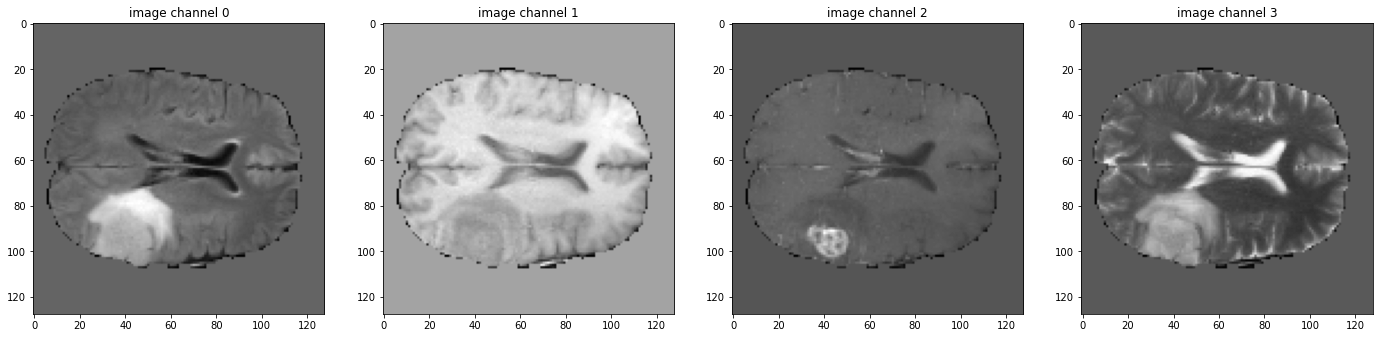

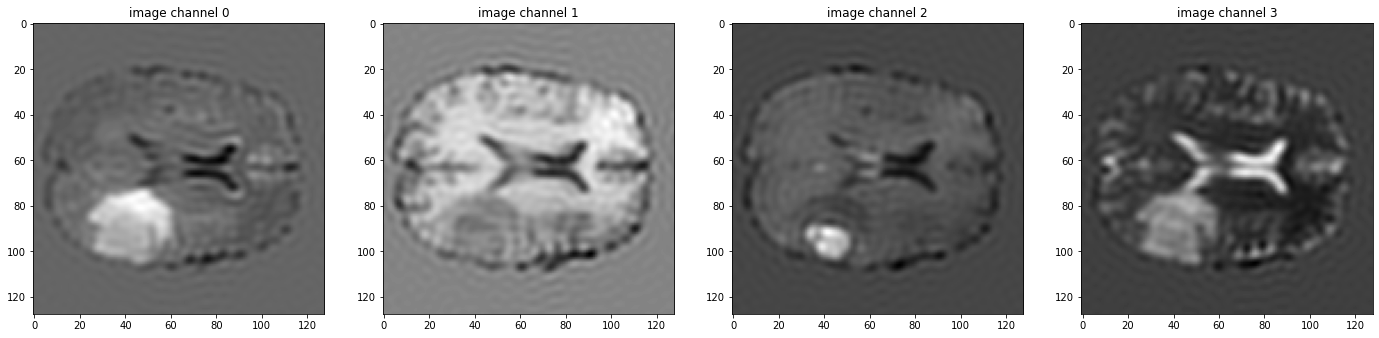

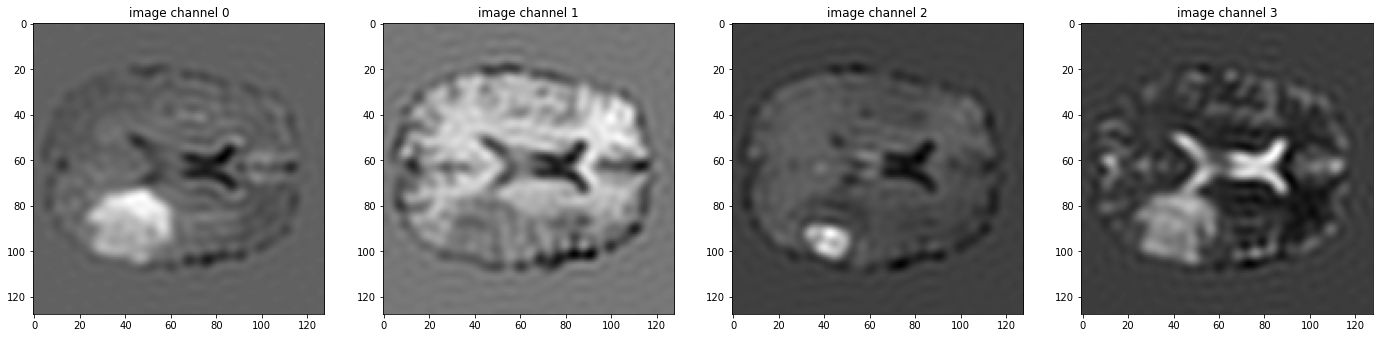

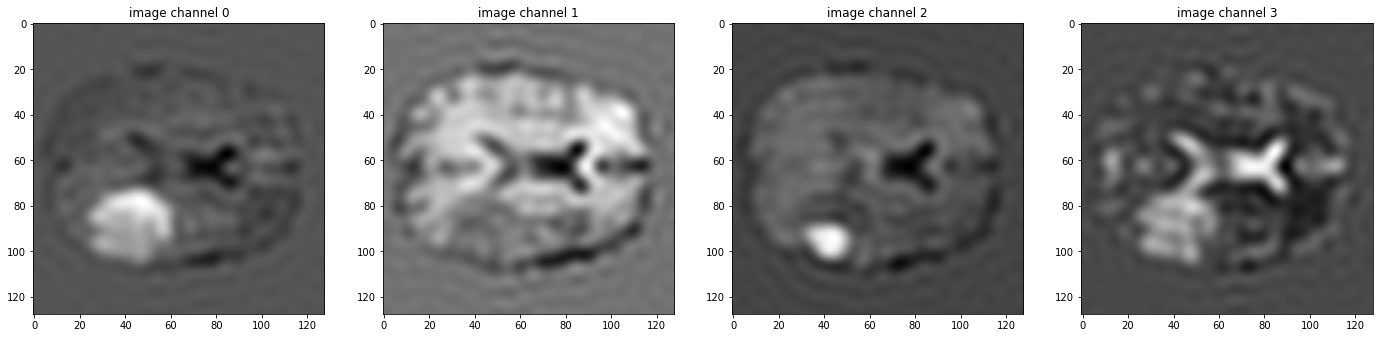

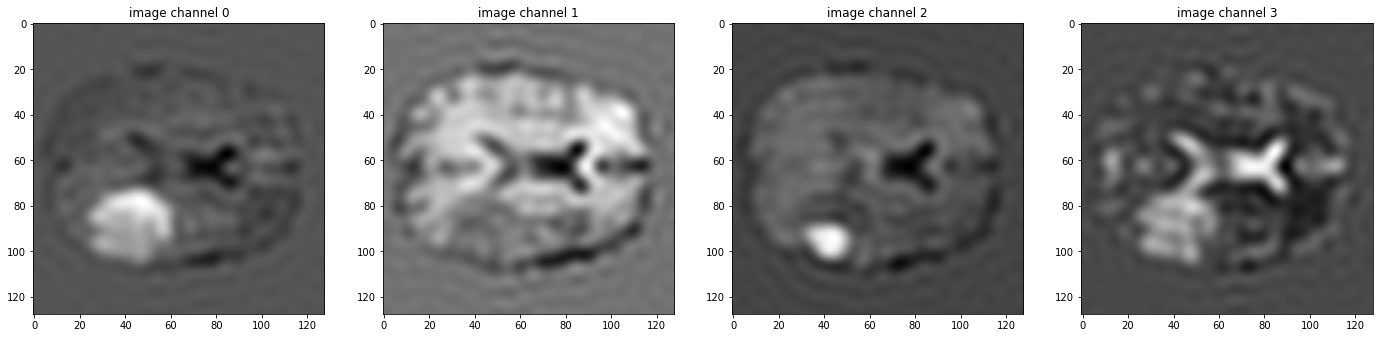

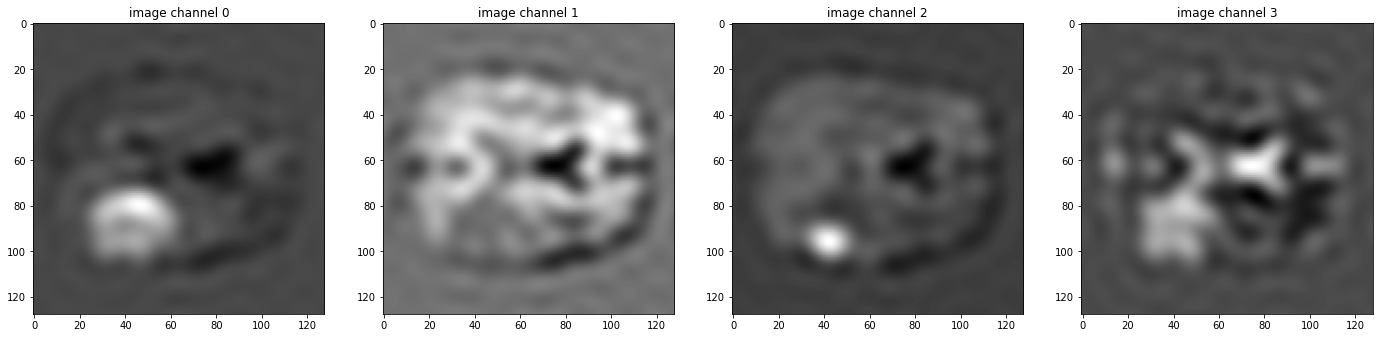

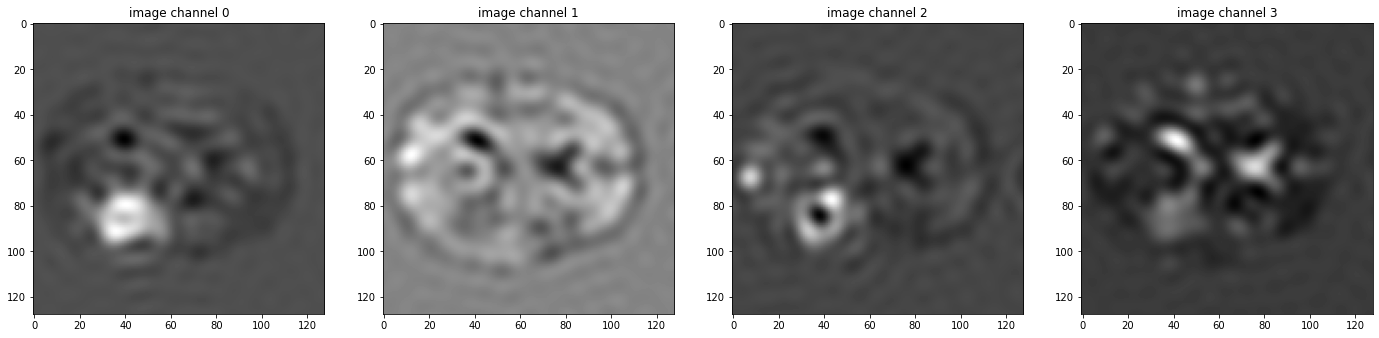

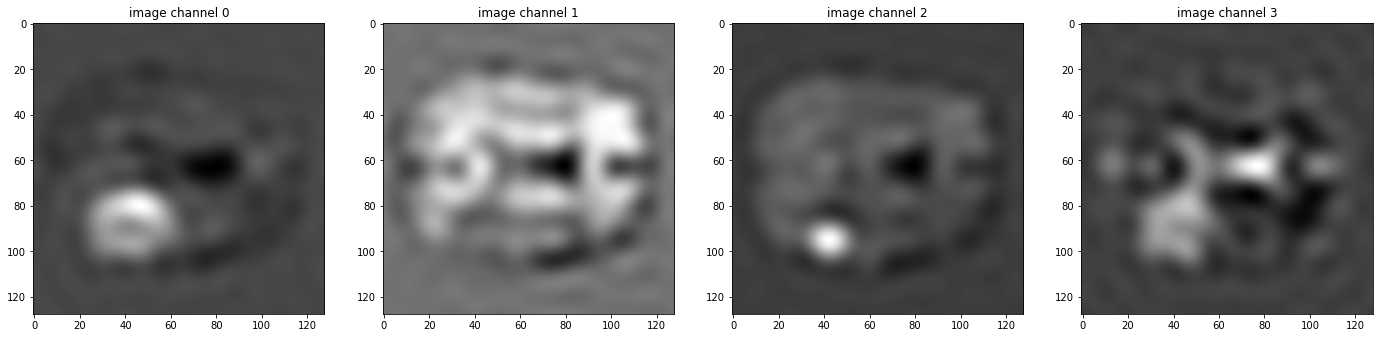

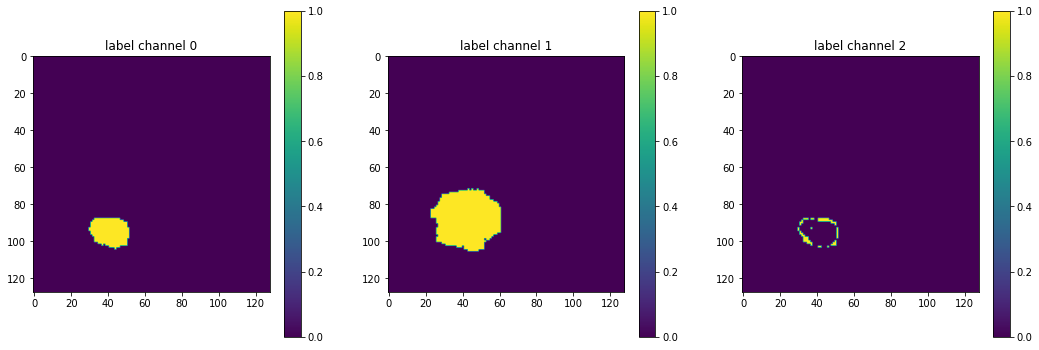

In [19]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
sample_images = [test_ds_baseline[20]['image'],
                 test_ds_gibbs25[20]['image'],
                 test_ds_gibbs20[20]['image'],
                 test_ds_gibbs15[20]['image'],
                 test_ds_gibbs15[20]['image'],
                 test_ds_gibbs10[20]['image'],
                 val_ds_gibbs12p5[20]['image'],
                 test_ds_gibbs9[20]['image']]

label = test_ds_baseline[20]['label']


for img in sample_images:
    plt.figure(figsize=(24,6))
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.title(f'image channel {i}')
        plt.imshow(img[i, :, :, 32].detach().cpu(), cmap="gray")
    plt.show()
    

# also visualize the 3 channels label corresponding to this image
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(label[i, :, :, 32].detach().cpu())
    plt.colorbar()
plt.show()

# Inference

In [12]:
for file in os.listdir(root_dir):
    if file.endswith('pth'):
        print(file)

best_metric_model_monai_data.pth
best_metric_model_baseline.pth
best_metric_model_Gibbs35.pth
best_metric_model_Gibbs25.pth
best_metric_model_Gibbs15.pth
best_metric_model_Gibbs10.pth
best_metric_model_Gibbs20.pth
best_metric_model_Gibbs12.5.pth
best_metric_model_Gibbs9.pth
best_metric_model_Gibbs10-25.pth
best_metric_model_planes_a55.0b55.0c30.0_int12.0.pth
best_metric_model_planes_a55.0b55.0c30.0_int14.0.pth
best_metric_model_planes_a55.0b55.0c30.0_int13.0.pth
best_metric_model_planes_a55.0b55.0c30.0_int15.0.pth
best_metric_model_planes_a55.0b55.0c30.0_int16.0.pth
best_metric_model_planes_a55.0b55.0c30.0_int17.0.pth
best_metric_model_planes_a55.0b55.0c30.0_int16.5.pth


## Check models' output with the input image and label

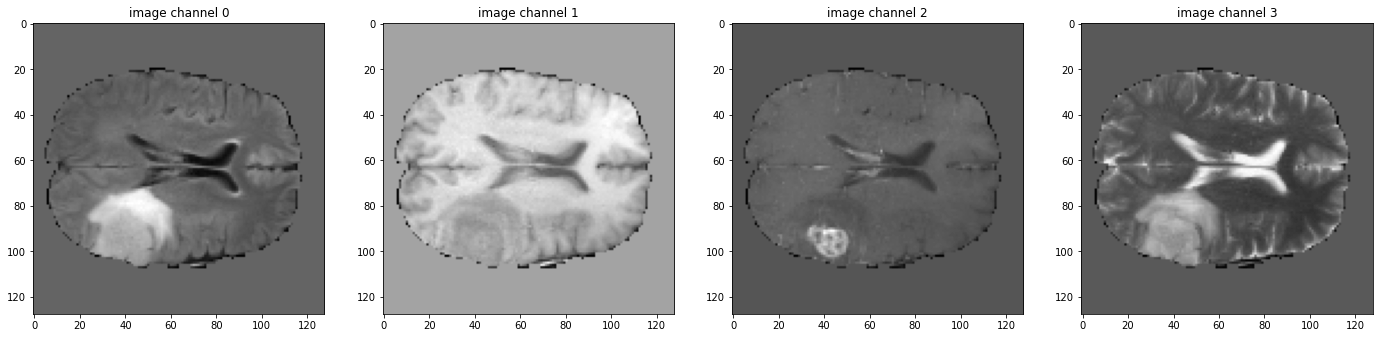

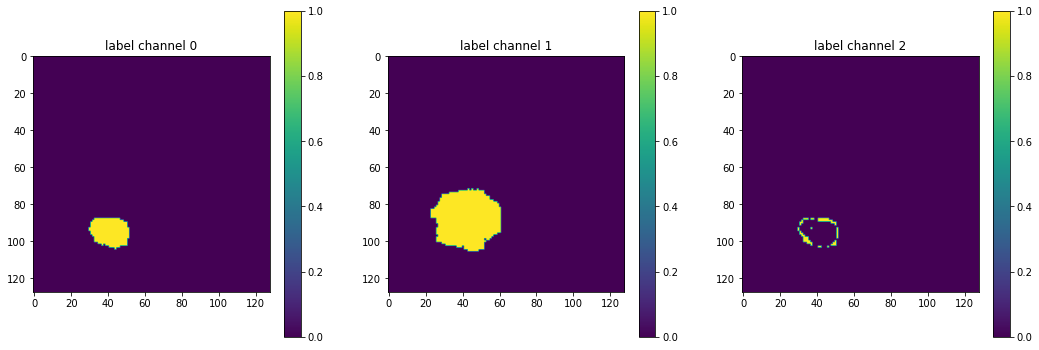

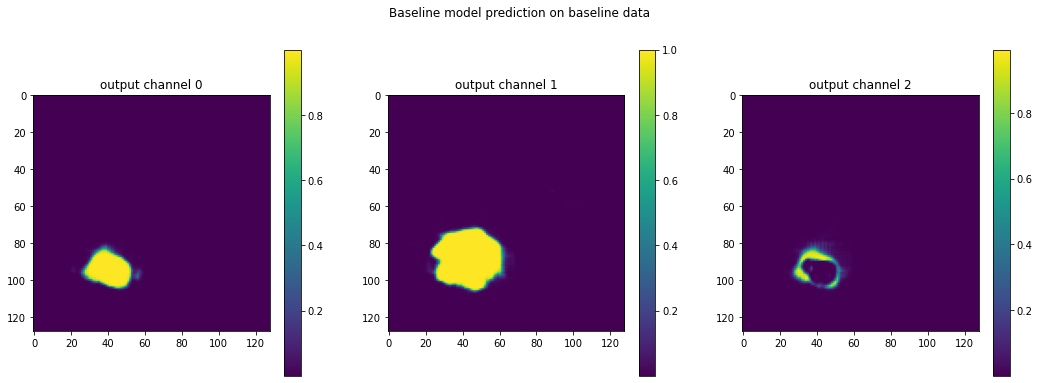

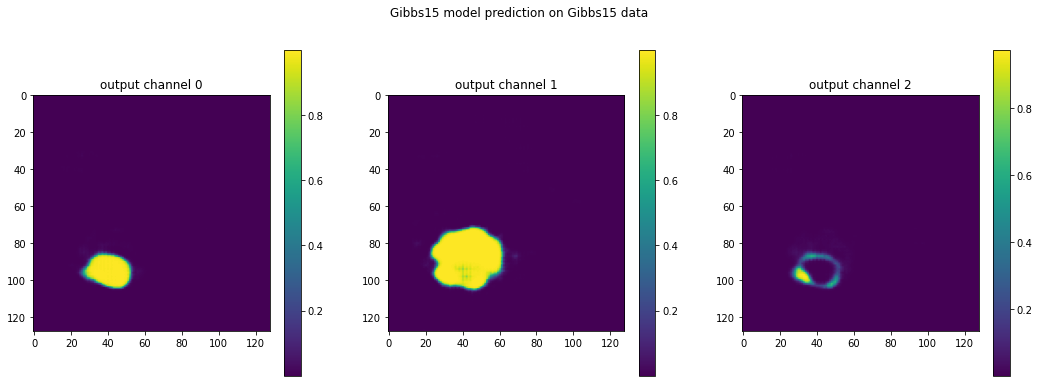

In [34]:
baseline.model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = img_base.unsqueeze(0).to(device)
    val_output = baseline.model(val_input)
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(img_base[i, :, :, 32].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(label[i, :, :, 32].detach().cpu())
        plt.colorbar()
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("baseline", (18, 6))
    plt.suptitle('Baseline model prediction on baseline data')
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(torch.sigmoid(val_output[0, i, :, :, 32].detach().cpu()))
        plt.colorbar()
    plt.show()
    
    # Gibbs15 model/data 
    gibbs15.model.eval()
    val_input = img_gibbs15.unsqueeze(0).to(device)
    val_output = gibbs15.model(val_input)
    plt.figure("gibbs15", (18, 6))
    plt.suptitle('Gibbs15 model prediction on Gibbs15 data')
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(torch.sigmoid(val_output[0, i, :, :, 32].detach().cpu()))
        plt.colorbar()
    plt.show()

## Model comparisons

### Evaluations

In [14]:
baseline = model_evaluation('best_metric_model_baseline.pth', 'baseline model')
baseline.add_eval('baseline_data', test_loader_baseline)
baseline.add_eval('gibbs25_data', test_loader_gibbs25)
baseline.add_eval('gibbs20_data', test_loader_gibbs20)
baseline.add_eval('gibbs15_data', test_loader_gibbs15)
baseline.add_eval('gibbs12.5_data', test_loader_gibbs12p5)
baseline.add_eval('gibbs10_data', test_loader_gibbs10)
baseline.add_eval('gibbs9_data', test_loader_gibbs9)

100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


In [15]:
gibbs25 = model_evaluation('best_metric_model_Gibbs25.pth', 'Gibbs25_model')
gibbs25.add_eval('baseline_data', test_loader_baseline)
gibbs25.add_eval('gibbs25_data', test_loader_gibbs25)
gibbs25.add_eval('gibbs20_data', test_loader_gibbs20)
gibbs25.add_eval('gibbs15_data', test_loader_gibbs15)
gibbs25.add_eval('gibbs12.5_data', test_loader_gibbs12p5)
gibbs25.add_eval('gibbs10_data', test_loader_gibbs10)
gibbs25.add_eval('gibbs9_data', test_loader_gibbs9)
gibbs25.save()

100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


In [16]:
gibbs20 = model_evaluation('best_metric_model_Gibbs20.pth', 'Gibbs20_model')
gibbs20.add_eval('baseline_data', test_loader_baseline)
gibbs20.add_eval('gibbs25_data', test_loader_gibbs25)
gibbs20.add_eval('gibbs20_data', test_loader_gibbs20)
gibbs20.add_eval('gibbs15_data', test_loader_gibbs15)
gibbs20.add_eval('gibbs12.5_data', test_loader_gibbs12p5)
gibbs20.add_eval('gibbs10_data', test_loader_gibbs10)
gibbs20.add_eval('gibbs9_data', test_loader_gibbs9)
gibbs20.save()

100%|██████████| 24/24 [00:23<00:00,  1.00it/s]


In [17]:
gibbs15 = model_evaluation('best_metric_model_Gibbs15.pth', 'Gibbs15_model')
gibbs15.add_eval('baseline_data', test_loader_baseline)
gibbs15.add_eval('gibbs25_data', test_loader_gibbs25)
gibbs15.add_eval('gibbs20_data', test_loader_gibbs20)
gibbs15.add_eval('gibbs15_data', test_loader_gibbs15)
gibbs15.add_eval('gibbs12.5_data', test_loader_gibbs12p5)
gibbs15.add_eval('gibbs10_data', test_loader_gibbs10)
gibbs15.add_eval('gibbs9_data', test_loader_gibbs9)
gibbs15.save()

100%|██████████| 24/24 [00:19<00:00,  1.20it/s]


In [18]:
gibbs12p5 = model_evaluation('best_metric_model_Gibbs12.5.pth', 'Gibbs12.5_model')
gibbs12p5.add_eval('baseline_data', test_loader_baseline)
gibbs12p5.add_eval('gibbs25_data', test_loader_gibbs25)
gibbs12p5.add_eval('gibbs20_data', test_loader_gibbs20)
gibbs12p5.add_eval('gibbs15_data', test_loader_gibbs15)
gibbs12p5.add_eval('gibbs12.5_data', test_loader_gibbs12p5)
gibbs12p5.add_eval('gibbs10_data', test_loader_gibbs10)
gibbs12p5.add_eval('gibbs9_data', test_loader_gibbs9)
gibbs12p5.save()

100%|██████████| 24/24 [00:19<00:00,  1.20it/s]


In [19]:
gibbs10 = model_evaluation('best_metric_model_Gibbs10.pth', 'Gibbs10_model')
gibbs10.add_eval('baseline_data', test_loader_baseline)
gibbs10.add_eval('gibbs25_data', test_loader_gibbs25)
gibbs10.add_eval('gibbs20_data', test_loader_gibbs20)
gibbs10.add_eval('gibbs15_data', test_loader_gibbs15)
gibbs10.add_eval('gibbs12.5_data', test_loader_gibbs12p5)
gibbs10.add_eval('gibbs10_data', test_loader_gibbs10)
gibbs10.add_eval('gibbs9_data', test_loader_gibbs9)
gibbs10.save()

100%|██████████| 24/24 [00:26<00:00,  1.10s/it]


In [20]:
gibbs9 = model_evaluation('best_metric_model_Gibbs9.pth', 'Gibbs9_model')
gibbs9.add_eval('baseline_data', test_loader_baseline)
gibbs9.add_eval('gibbs25_data', test_loader_gibbs25)
gibbs9.add_eval('gibbs20_data', test_loader_gibbs20)
gibbs9.add_eval('gibbs15_data', test_loader_gibbs15)
gibbs9.add_eval('gibbs12.5_data', test_loader_gibbs12p5)
gibbs9.add_eval('gibbs10_data', test_loader_gibbs10)
gibbs9.add_eval('gibbs9_data', test_loader_gibbs9)
gibbs9.save()

100%|██████████| 24/24 [00:21<00:00,  1.12it/s]


#### Interval Gibbs models

In [32]:
gibbs10to25 = model_evaluation('best_metric_model_Gibbs10-25.pth', 'Gibbs10-25 model')
gibbs10to25.add_eval('baseline_data', test_loader_baseline)
gibbs10to25.add_eval('gibbs25_data', test_loader_gibbs25)
gibbs10to25.add_eval('gibbs20_data', test_loader_gibbs20)
gibbs10to25.add_eval('gibbs15_data', test_loader_gibbs15)
gibbs10to25.add_eval('gibbs12.5_data', test_loader_gibbs12p5)
gibbs10to25.add_eval('gibbs10_data', test_loader_gibbs10)
gibbs10to25.add_eval('gibbs9_data', test_loader_gibbs9)

100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


### Load saved metrics

We load saved model_evaluations if they exist.

In [17]:
%ls

80_learning_curves/                     Gibbs12.5_model.pickle
baseline_model_2.pickle                 Gibbs15_model.pickle
baseline_model.pickle                   Gibbs20_model.pickle
brats_segmentation_3d_Gibbs_test.ipynb  Gibbs25_model.pickle
Gibbs10_model.pickle                    Gibbs9_model.pickle


In [53]:
baseline = model_evaluation(None,instance_name='baseline model')
gibbs25 = model_evaluation(None, instance_name='Gibbs25_model')
gibbs20 = model_evaluation(None,instance_name='Gibbs25_model')
gibbs15 = model_evaluation(None,instance_name='Gibbs15_model')
gibbs12p5 = model_evaluation(None,instance_name='Gibbs12.5_model')
gibbs10 = model_evaluation(None,instance_name='Gibbs10_model')
gibbs9 = model_evaluation(None,instance_name='Gibbs9_model')

baseline.load_dict('baseline_model.pickle')
gibbs25.load_dict('Gibbs25_model.pickle')
gibbs20.load_dict('Gibbs20_model.pickle')
gibbs15.load_dict('Gibbs15_model.pickle')
gibbs12p5.load_dict('Gibbs12.5_model.pickle')
gibbs10.load_dict('Gibbs10_model.pickle')
gibbs9.load_dict('Gibbs9_model.pickle')

In [88]:
def plot_model_performance(gibbs_values:list, model_evals:list, metric:str, figsize:tuple = None, xlim:tuple=None, ylim:tuple=None):
    '''
    Plots each model's performance over a range of stylized 
    datasets.
    
    Args: 
        gibbs_values = list of Gibbs values associated with each
            test dataset.
        model_evals = instances of the model_evaluation class
            for each model to evaluate.
        metric = one of [mean, et, tc, wt].
    '''
    metrics_map ={'mean':0, 'et':1, 'tc':2, 'wt':3}
    keys = model_evals[0].eval_dict.keys()
    plt.figure(figsize=figsize)
    for model in model_evals:
        vals = []
        for k in keys:
            vals.append(dict(model.eval_dict)[k][metrics_map[metric]])
        plt.plot(gibbs_values,list(reversed(vals)),'-*',label=model.instance_name)
    plt.legend()
    plt.xlabel('Gibbs-stylized test data')
    plt.title(metric+' Dice score for each Gibbs-stylized model')
    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)
        plt.yticks(np.arange(min(ylim), max(ylim), .02))
    plt.show()
    

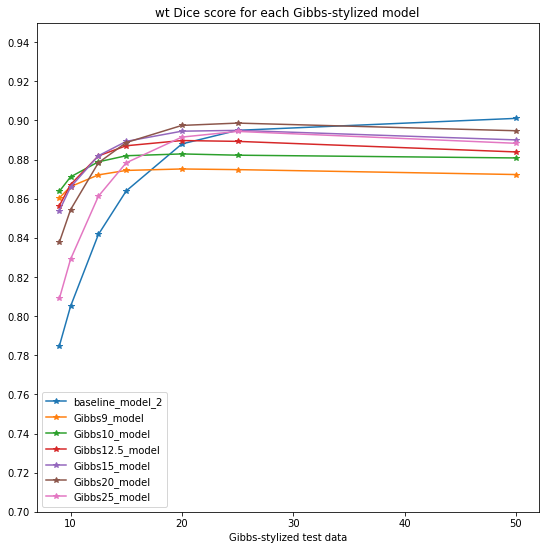

In [90]:
plot_model_performance([9, 10,12.5,15,20,25,50],[baseline,gibbs9, gibbs10, gibbs12p5, gibbs15, gibbs20, gibbs25],'wt', figsize=(9,9),ylim = (.7,.95))

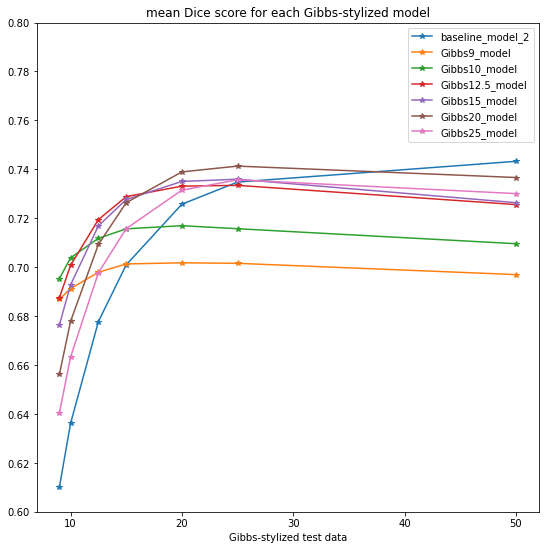

In [92]:
plot_model_performance([9, 10,12.5,15,20,25,50],[baseline,gibbs9, gibbs10, gibbs12p5, gibbs15, gibbs20, gibbs25],'mean', figsize=(9,9),ylim = (.6,.8))

# Plane wave models

In [9]:
planes12 = model_evaluation('best_metric_model_planes_a55.0b55.0c30.0_int12.0.pth', 'Planes12 model')
planes14 = model_evaluation('best_metric_model_planes_a55.0b55.0c30.0_int14.0.pth', 'Planes14 model')
planes15 = model_evaluation('best_metric_model_planes_a55.0b55.0c30.0_int15.0.pth', 'Planes15 model')
planes16 = model_evaluation('best_metric_model_planes_a55.0b55.0c30.0_int16.0.pth', 'Planes16 model')
planes16p5 = model_evaluation('best_metric_model_planes_a55.0b55.0c30.0_int16.5.pth', 'Planes16.5 model')
planes17 = model_evaluation('best_metric_model_planes_a55.0b55.0c30.0_int17.0.pth', 'Planes17 model')

In [10]:
planes12.load_dict('Planes12_model.pickle')
planes14.load_dict('Planes14_model.pickle')
planes15.load_dict('Planes15_model.pickle')
planes16.load_dict('Planes16_model.pickle')
planes16p5.load_dict('Planes16.5_model.pickle')
planes17.load_dict('Planes17_model.pickle')

In [13]:
planes12.load_UNet('best_metric_model_planes_a55.0b55.0c30.0_int12.0.pth')
planes14.load_UNet('best_metric_model_planes_a55.0b55.0c30.0_int14.0.pth')
planes15.load_UNet('best_metric_model_planes_a55.0b55.0c30.0_int15.0.pth')
planes16.load_UNet('best_metric_model_planes_a55.0b55.0c30.0_int16.0.pth')
planes16p5.load_UNet('best_metric_model_planes_a55.0b55.0c30.0_int16.5.pth')
planes17.load_UNet('best_metric_model_planes_a55.0b55.0c30.0_int17.0.pth')

In [18]:
gibbs_data_dict = dict([
    ('gibbs25_data', test_loader_gibbs25),
    ('gibbs20_data', test_loader_gibbs20),
    ('gibbs15_data', test_loader_gibbs15),
    ('gibbs12.5_data', test_loader_gibbs12p5),
    ('gibbs10_data', test_loader_gibbs10),
    ('gibbs9_data', test_loader_gibbs9)
])

planes_models = [planes12,planes14,planes15,planes16,planes16p5, planes17]

for x in planes_models:
    for name in gibbs_data_dict:
        x.add_eval(name, gibbs_data_dict[name])
    x.instance_name = x.instance_name + '_2'
    x.save()

100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


In [10]:
baseline = model_evaluation('best_metric_model_baseline.pth', 'baseline model')
baseline.load_dict('baseline_model.pickle')
gibbs_data_dict = dict([
    ('gibbs25_data', test_loader_gibbs25),
    ('gibbs20_data', test_loader_gibbs20),
    ('gibbs15_data', test_loader_gibbs15),
    ('gibbs12.5_data', test_loader_gibbs12p5),
    ('gibbs10_data', test_loader_gibbs10),
    ('gibbs9_data', test_loader_gibbs9)
])

for name in gibbs_data_dict:
    baseline.add_eval(name, gibbs_data_dict[name])
baseline.instance_name = baseline.instance_name + '_2'
baseline.save()

100%|██████████| 24/24 [00:23<00:00,  1.03it/s]


In [13]:
baseline.eval_dict

defaultdict(list,
            {'baseline_data': (0.7432693392038345,
              0.5489715797205766,
              0.7797949202358723,
              0.9010415002703667),
             'planes12_data': (0.7378606622417768,
              0.5440621636807919,
              0.773770198225975,
              0.895749643445015),
             'planes14_data': (0.6510944416125616,
              0.4575871266424656,
              0.6771040807167689,
              0.8185921385884285),
             'planes15_data': (0.6014503948390484,
              0.3955950648523867,
              0.6186110861599445,
              0.7901450420419375),
             'planes16_data': (0.27854293895264465,
              0.10160165720541652,
              0.26536919095087796,
              0.4686579580108325),
             'planes16.5_data': (0.07187439315021038,
              0.0077993803344422,
              0.044744124679709785,
              0.1630796816510459),
             'planes17_data': (0.018005432105079915,